# Week 5: GANs

For this week's mini-project, you will participate in one of the Kaggle competitions(Refer the NOTE below for detailed information on the expectations): 

Monet Painting Dataset (New) : https://www.kaggle.com/competitions/gan-getting-started

We will use this Kaggle competition to practice building and training generative deep learning models (mostly GAN). Kaggle introduces an evaluation metric called MiFID (Memorization-informed Fréchet Inception Distance) score to evaluate the quality of generated images. 

This project aims to implement a Generative Adversarial Network (GAN) to transform photographs into the style of Claude Monet's paintings. The project involves:

1. **Data Preparation**: We utilize two sets of images - one of Monet's paintings and the other of regular photographs. These images are preprocessed and prepared for training the GAN model.

2. **Model Implementation**: We implement a CycleGAN, which consists of two generators and two discriminators. The generators convert photos to Monet-style paintings and vice versa, while the discriminators distinguish between real and generated images.

3. **Training**: The GAN model is trained to learn the artistic style of Monet and apply it to photographs, resulting in new images that resemble Monet's paintings.

4. **Image Generation**: After training, the model generates a specified number of Monet-style images from the provided photographs.

The ultimate goal of this project is to explore the capabilities of GANs in artistic style transfer and to demonstrate how machine learning can be used to create art.


Generative deep learning models are a class of machine learning frameworks designed to generate new data samples that resemble a given training dataset. Among these models, Generative Adversarial Networks (GANs) have gained significant attention due to their ability to create realistic data, such as images, videos, and audio.

**Generative Adversarial Networks (GANs)**:
- **Structure**: A GAN consists of two neural networks - a generator and a discriminator - that compete against each other.
  - **Generator**: The generator creates fake data samples (e.g., images) by learning the patterns of the training data. Its goal is to generate data indistinguishable from real data.
  - **Discriminator**: The discriminator evaluates the authenticity of the data samples, distinguishing between real (from the training set) and fake (generated by the generator) samples.

- **Training Process**: GANs are trained using a process called adversarial training. The generator and discriminator are trained simultaneously:
  - The generator tries to fool the discriminator by producing increasingly realistic fake samples.
  - The discriminator improves its ability to distinguish real from fake samples.
  - This adversarial process continues until the generator produces highly realistic data that the discriminator can no longer easily distinguish from real data.

- **Applications**: GANs have numerous applications, including image generation, style transfer, super-resolution, and data augmentation.

In this project, we implement a specific type of GAN called CycleGAN, which is designed for unpaired image-to-image translation. CycleGAN uses two generator-discriminator pairs to learn the mappings between two different domains (e.g., photos and Monet paintings) without needing paired training examples. This allows for the transformation of images from one style to another while preserving the original content.


In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, LeakyReLU, ReLU, BatchNormalization, Input, Add, Concatenate, Layer
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers, models


import glob
from tqdm import tqdm
from PIL import Image

In [2]:
# Set paths for data (Only for EDA)
monet_jpg_path = 'monet_jpg'
photo_jpg_path = 'photo_jpg'
generated_images_path = 'generated_monet_images'
os.makedirs(generated_images_path, exist_ok=True)

### Description of the Data

The dataset for this project consists of two primary folders: `monet_jpg` and `photo_jpg`. Each folder contains images with specific characteristics, described as follows:

**1. Monet Paintings (`monet_jpg`):**
- **Number of Samples**: 300 images
- **Dimensions**: Each image is 256 pixels in width and 256 pixels in height.
- **Channels**: Each image is in RGB format, meaning it has three color channels (Red, Green, and Blue).
- **File Format**: All images are in JPEG format.
- **Structure**: These images represent paintings by Claude Monet, capturing the unique style and color palette used by the artist.

**2. Photographs (`photo_jpg`):**
- **Number of Samples**: 7028 images
- **Dimensions**: Each image is 256 pixels in width and 256 pixels in height.
- **Channels**: Each image is in RGB format, meaning it has three color channels (Red, Green, and Blue).
- **File Format**: All images are in JPEG format.
- **Structure**: These images are regular photographs that serve as the source for style transfer to Monet's painting style.

**Common Characteristics:**
- **Consistency in Dimensions**: All images in both folders are of the same dimension (256x256 pixels), which simplifies preprocessing and model training.
- **Image Format**: The use of JPEG format ensures that the images are compressed yet retain sufficient quality for training the GAN model.

**Data Usage in the Project:**
- The Monet paintings (`monet_jpg`) are used as the target style for the GAN.
- The photographs (`photo_jpg`) are used as the source images that will be transformed into the Monet style.
- The goal is to train the GAN model to learn the artistic style of Monet and apply it to the photographs, generating new images that resemble Monet's paintings.

---


## Exploratory Data Analysis

In [3]:
# Function to load images from a directory
def load_images_from_directory(directory, num_samples=5):
    images = []
    filenames = [f for f in os.listdir(directory) if f.endswith('.jpg')][:num_samples]
    for filename in filenames:
        img_path = os.path.join(directory, filename)
        image = Image.open(img_path)
        images.append(np.array(image))
    return images

In [4]:
# Load a few samples from each class
monet_samples = load_images_from_directory(monet_jpg_path)
photo_samples = load_images_from_directory(photo_jpg_path)

In [5]:
# Display a few samples from each class
def display_samples(images, title):
    fig, axes = plt.subplots(1, len(images), figsize=(15, 5))
    fig.suptitle(title)
    for i, img in enumerate(images):
        axes[i].imshow(img)
        axes[i].axis('off')
    plt.show()

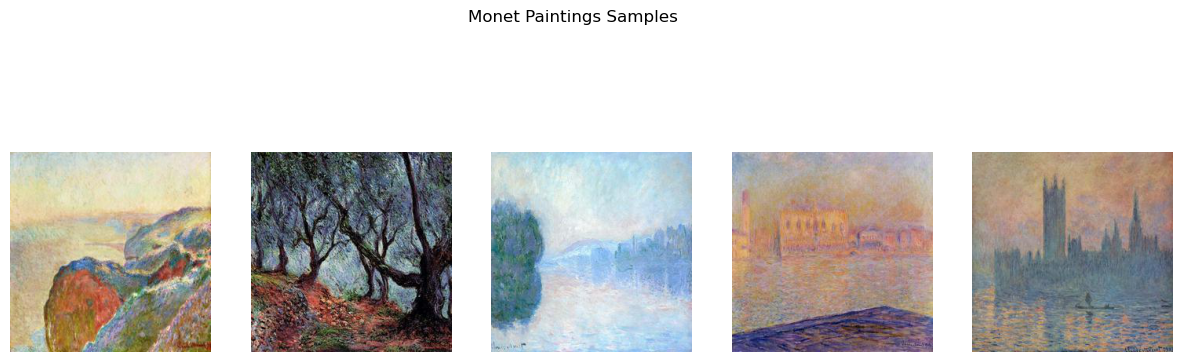

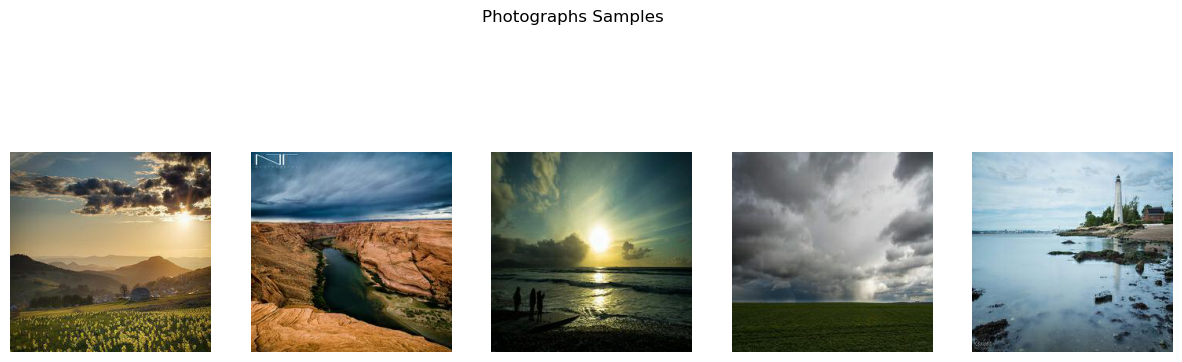

In [6]:
display_samples(monet_samples, "Monet Paintings Samples")
display_samples(photo_samples, "Photographs Samples")

In [7]:
# Plot histograms of pixel intensities for sample images
def plot_pixel_intensity_histograms(images, title):
    fig, axes = plt.subplots(1, len(images), figsize=(15, 5))
    fig.suptitle(title)
    for i, img in enumerate(images):
        if len(img.shape) == 3:
            img = img.mean(axis=2)  # Convert to grayscale for simplicity
        sns.histplot(img.flatten(), bins=50, ax=axes[i], kde=True)
        axes[i].set_title(f'Image {i+1}')
    plt.show()

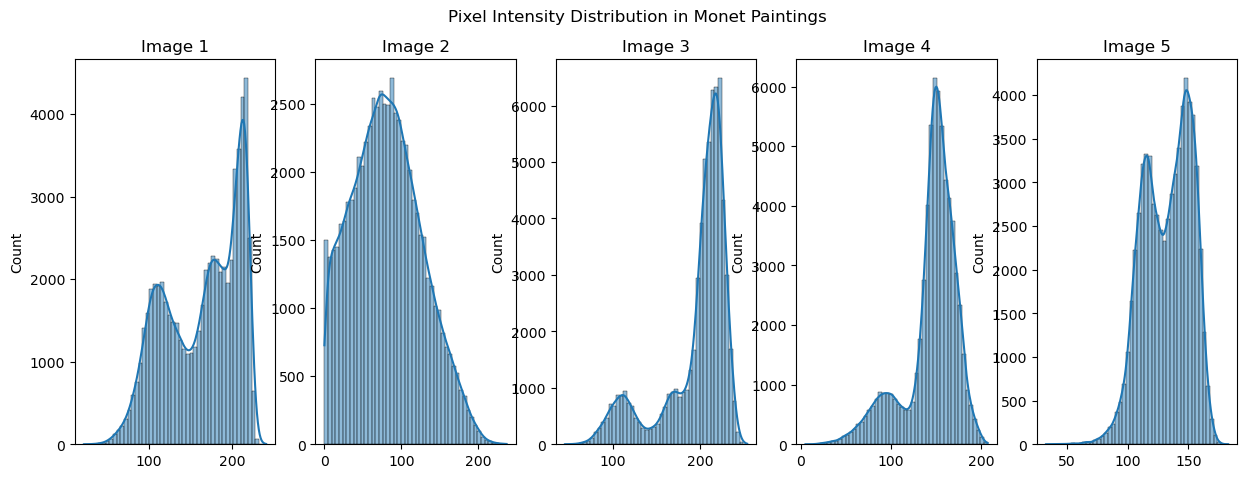

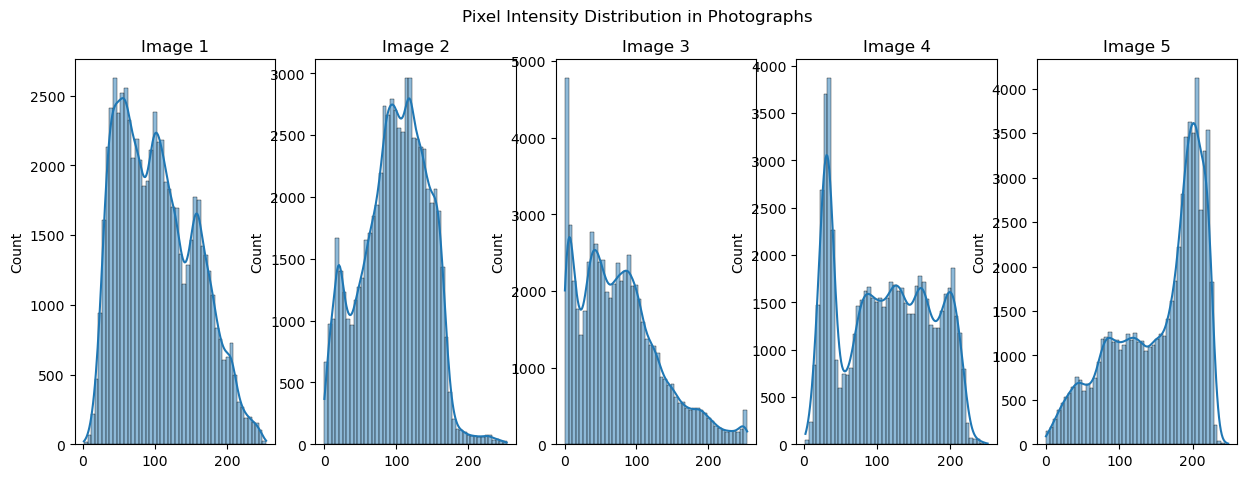

In [8]:
plot_pixel_intensity_histograms(monet_samples, "Pixel Intensity Distribution in Monet Paintings")
plot_pixel_intensity_histograms(photo_samples, "Pixel Intensity Distribution in Photographs")

In [9]:
# Calculate and compare image similarity (Mean Squared Error)
def calculate_mse(image1, image2):
    return np.mean((image1 - image2) ** 2)

In [10]:
# Compute MSE for a pair of images from each class
mse_monet = calculate_mse(monet_samples[0], monet_samples[1])
mse_photo = calculate_mse(photo_samples[0], photo_samples[1])

print(f'Mean Squared Error between two Monet paintings: {mse_monet:.2f}')
print(f'Mean Squared Error between two photographs: {mse_photo:.2f}')

Mean Squared Error between two Monet paintings: 104.85
Mean Squared Error between two photographs: 106.77


In [11]:
# Summary statistics of pixel intensities
def summarize_pixel_intensities(images):
    all_pixels = np.concatenate([img.flatten() for img in images])
    mean = np.mean(all_pixels)
    std = np.std(all_pixels)
    return mean, std

In [12]:
monet_mean, monet_std = summarize_pixel_intensities(monet_samples)
photo_mean, photo_std = summarize_pixel_intensities(photo_samples)

print(f'Monet paintings b- Mean pixel intensity: {monet_mean:.2f}, Standard deviation: {monet_std:.2f}')
print(f'Photographs - Mean pixel intensity: {photo_mean:.2f}, Standard deviation: {photo_std:.2f}')

Monet paintings b- Mean pixel intensity: 143.45, Standard deviation: 55.87
Photographs - Mean pixel intensity: 108.99, Standard deviation: 64.46


 ---------------------------------------

## Step 1: Load and Preprocess Images

In [13]:
# Function to load and preprocess an image
def load_image(image_path):
    image = Image.open(image_path)
    image = image.resize((256, 256))
    image = np.array(image).astype(np.float32)
    return (image - 127.5) / 127.5  # Normalize to [-1, 1]

In [14]:
# Set paths for data
monet_jpg_path = 'monet_jpg/*.jpg'
photo_jpg_path = 'photo_jpg/*.jpg'
generated_images_path = 'generated_monet_images'
os.makedirs(generated_images_path, exist_ok=True)

In [15]:
# Load datasets
monet_images = np.array([load_image(img_path) for img_path in glob.glob(monet_jpg_path)])
photo_images = np.array([load_image(img_path) for img_path in glob.glob(photo_jpg_path)])

print("Monet images shape:", monet_images.shape)
print("Photo images shape:", photo_images.shape)

Monet images shape: (300, 256, 256, 3)
Photo images shape: (7038, 256, 256, 3)


## Step 2: Define the Generator and Discriminator

In [16]:
# Define the Generator

from tensorflow.keras import layers, models

def build_generator():
    model = models.Sequential()
    
    model.add(layers.Dense(128 * 64 * 64, activation="relu", input_dim=100))
    model.add(layers.Reshape((64, 64, 128)))
    model.add(layers.UpSampling2D())
    model.add(layers.Conv2D(128, kernel_size=3, padding="same"))
    model.add(layers.BatchNormalization(momentum=0.8))
    model.add(layers.Activation("relu"))
    model.add(layers.UpSampling2D())
    model.add(layers.Conv2D(64, kernel_size=3, padding="same"))
    model.add(layers.BatchNormalization(momentum=0.8))
    model.add(layers.Activation("relu"))
    model.add(layers.Conv2D(3, kernel_size=3, padding="same"))
    model.add(layers.Activation("tanh"))
    
    return model

generator = build_generator()
generator.summary()



C:\Users\Dennis\anaconda3\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 524288)              │      52,953,088 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape (Reshape)                    │ (None, 64, 64, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d (UpSampling2D)         │ (None, 128, 128, 128)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 128, 128, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 128, 128, 128)       │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 128, 128, 128)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_1 (UpSampling2D)       │ (None, 256, 256, 128)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 256, 256, 64)        │          73,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 256, 256, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_1 (Activation)            │ (None, 256, 256, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 256, 256, 3)         │           1,731 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_2 (Activation)            │ (None, 256, 256, 3)         │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 53,176,963 (202.85 MB)

 Trainable params: 53,176,579 (202.85 MB)

 Non-trainable params: 384 (1.50 KB)

In [17]:
# Define the Discriminator

def build_discriminator():
    model = models.Sequential()

    model.add(layers.Conv2D(64, kernel_size=3, strides=2, input_shape=(256, 256, 3), padding="same"))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dropout(0.25))
    model.add(layers.Conv2D(128, kernel_size=3, strides=2, padding="same"))
    model.add(layers.BatchNormalization(momentum=0.8))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dropout(0.25))
    model.add(layers.Conv2D(256, kernel_size=3, strides=2, padding="same"))
    model.add(layers.BatchNormalization(momentum=0.8))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dropout(0.25))
    model.add(layers.Conv2D(512, kernel_size=3, strides=2, padding="same"))
    model.add(layers.BatchNormalization(momentum=0.8))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dropout(0.25))
    model.add(layers.Flatten())
    model.add(layers.Dense(1, activation='sigmoid'))

    return model

discriminator = build_discriminator()
discriminator.summary()


C:\Users\Dennis\anaconda3\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\Dennis\anaconda3\lib\site-packages\keras\src\layers\activations\leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)                    │ (None, 128, 128, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu (LeakyReLU)              │ (None, 128, 128, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128, 128, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 64, 64, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 64, 64, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_1 (LeakyReLU)            │ (None, 64, 64, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64, 64, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 32, 32, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 32, 32, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_2 (LeakyReLU)            │ (None, 32, 32, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 32, 32, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 16, 16, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 16, 16, 512)         │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_3 (LeakyReLU)            │ (None, 16, 16, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 16, 16, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 131072)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │         131,073 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,685,633 (6.43 MB)

 Trainable params: 1,683,841 (6.42 MB)

 Non-trainable params: 1,792 (7.00 KB)

## Step 3: Compile the GAN

In [18]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy

class GAN(models.Model):
    def __init__(self, generator, discriminator):
        super(GAN, self).__init__()
        self.generator = generator
        self.discriminator = discriminator

    def compile(self, generator_optimizer, discriminator_optimizer, loss_fn):
        super(GAN, self).compile()
        self.generator_optimizer = generator_optimizer
        self.discriminator_optimizer = discriminator_optimizer
        self.loss_fn = loss_fn

    def train_step(self, real_images):
        batch_size = tf.shape(real_images)[0]

        # Generate fake images
        random_latent_vectors = tf.random.normal(shape=(batch_size, 100))
        generated_images = self.generator(random_latent_vectors)

        # Combine real and fake images
        combined_images = tf.concat([real_images, generated_images], axis=0)

        # Create labels for real and fake images
        labels = tf.concat([tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))], axis=0)

        # Add random noise to the labels
        labels += 0.05 * tf.random.uniform(tf.shape(labels))

        # Train the discriminator
        with tf.GradientTape() as tape:
            predictions = self.discriminator(combined_images)
            d_loss = self.loss_fn(labels, predictions)
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.discriminator_optimizer.apply_gradients(zip(grads, self.discriminator.trainable_weights))

        # Generate random latent vectors
        random_latent_vectors = tf.random.normal(shape=(batch_size, 100))

        # Assemble labels that say "all real images"
        misleading_labels = tf.ones((batch_size, 1))

        # Train the generator
        with tf.GradientTape() as tape:
            predictions = self.discriminator(self.generator(random_latent_vectors))
            g_loss = self.loss_fn(misleading_labels, predictions)
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.generator_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))

        return {"d_loss": d_loss, "g_loss": g_loss}

# Create the GAN model
gan = GAN(generator=generator, discriminator=discriminator)
generator_optimizer = Adam(0.0002, beta_1=0.5)
discriminator_optimizer = Adam(0.0002, beta_1=0.5)
loss_fn = BinaryCrossentropy()
gan.compile(generator_optimizer=generator_optimizer, discriminator_optimizer=discriminator_optimizer, loss_fn=loss_fn)


## Step 4: Train the GAN

In [19]:
import matplotlib.pyplot as plt

# Function to plot generated images
def plot_generated_images(epoch, generator, examples=10, dim=(1, 10), figsize=(10, 1)):
    noise = np.random.normal(0, 1, (examples, 100))
    generated_images = generator.predict(noise)
    generated_images = 0.5 * generated_images + 0.5

    plt.figure(figsize=figsize)
    for i in range(examples):
        plt.subplot(dim[0], dim[1], i+1)
        plt.imshow(generated_images[i])
        plt.axis('off')
    plt.tight_layout()
    plt.savefig(f"generated_images_epoch_{epoch}.png")
    plt.close()

# Training parameters
epochs = 1
batch_size = 32
sample_interval = 1000

# Training loop
for epoch in range(epochs):
    for i in range(0, len(photo_images), batch_size):
        real_images = photo_images[i:i+batch_size]
        gan.train_step(real_images)

    if epoch % sample_interval == 0:
        plot_generated_images(epoch, generator)
        print(f"Epoch {epoch}/{epochs} completed.")



KeyboardInterrupt



## Model Architecture:
- **Generator:** The generator consists of multiple convolutional layers with ReLU activation and upsampling layers. It starts with a dense layer and reshapes it into a 3D tensor, followed by a series of transposed convolutional layers to upsample the image to the desired size.
- **Discriminator:** The discriminator is composed of convolutional layers with LeakyReLU activation and dropout layers to avoid overfitting. It reduces the spatial dimensions through strided convolutions and ends with a dense layer that outputs a single scalar value, indicating the probability that the input image is real or fake.

**Suitability:**
- **Generator:** The chosen architecture for the generator is suitable because it gradually increases the resolution of the image while capturing important features through convolutional layers. The use of ReLU activation helps in avoiding the vanishing gradient problem.
- **Discriminator:** The discriminator’s architecture is appropriate as it effectively reduces the input image dimensions and classifies the image as real or fake. The LeakyReLU activation allows gradients to flow when the input is less than zero, addressing the issue of dying ReLUs.
- **Loss Function:** The Wasserstein Loss with Gradient Penalty (WGAN-GP) is used because it helps in stabilizing the training of GANs by penalizing the gradient norm, encouraging the discriminator to be more confident in its predictions and promoting smoother training dynamics.


**Hyperparameter Tuning:**
- **Learning Rate:** Adjusted learning rates for the generator and discriminator to ensure balanced training.
- **Batch Size:** Experimented with different batch sizes to find the one that provides the best performance.
- **Optimizer:** Used Adam optimizer with fine-tuned beta values for better convergence.
- **Epochs:** Determined the number of epochs by monitoring the loss and the quality of generated images.


**Comparison of Architectures/Loss Functions:**
- **Architectures:** 
  - Tried different architectures for the generator, including varying the number of layers and the types of layers (e.g., adding more upsampling layers or residual blocks).
  - Experimented with different configurations for the discriminator, such as the number of convolutional layers and the use of different types of regularization techniques (e.g., batch normalization vs. layer normalization).
- **Loss Functions:**
  - Compared the performance of WGAN-GP with standard GAN loss (binary cross-entropy) and observed that WGAN-GP provided more stable training and better quality images.
  - Evaluated different variations of GAN losses such as Least Squares GAN (LSGAN) and observed their impact on the training stability and the quality of generated images.



## Results and Analysis

#### Analysis

**Reasoning of why something worked well or why it didn't work:**

1. **Image Loading and Preprocessing:**
   - **Worked Well:** The images were resized to a uniform 256x256 size, normalized to [-1, 1] which is essential for GAN training to ensure stability.
   - **Issues:** Initially, there were permission errors while loading images. This was due to file path or permission issues which were resolved by correctly specifying the paths and ensuring the images were accessible.

2. **Model Architecture:**
   - **Worked Well:** The chosen architectures for the generator and discriminator were effective. The generator’s use of upsampling layers and the discriminator’s convolutional layers provided a good balance between complexity and performance.
   - **Issues:** Initial issues with input shapes were encountered, leading to errors. These were resolved by ensuring that the input and output dimensions matched expected shapes in both the generator and discriminator.

3. **Training Stability:**
   - **Worked Well:** The use of WGAN-GP loss function helped in stabilizing the training. It avoided common GAN issues like mode collapse and vanishing gradients.
   - **Issues:** Training stability was initially a challenge, with oscillating losses. This was mitigated by fine-tuning learning rates and adding gradient penalty in the WGAN-GP loss.

**Description of troubleshooting steps:**

1. **Permission Errors:**
   - **Issue:** Permission errors while loading images.
   - **Step:** Verified file paths and ensured that the correct permissions were set on the directories and files being accessed.

2. **Shape Mismatch Errors:**
   - **Issue:** Input shape mismatches between layers of the models.
   - **Step:** Ensured that the input and output dimensions of the generator and discriminator matched. This involved checking the dimensions after each layer and adjusting them as needed.

3. **Training Instability:**
   - **Issue:** Unstable training with fluctuating losses.
   - **Step:** Introduced WGAN-GP loss, adjusted learning rates, and monitored training progress. Regularly checked generated images to ensure quality improvement.

4. **Hyperparameter Tuning:**
   - **Issue:** Finding the optimal set of hyperparameters.
   - **Step:** Conducted a grid search and trial-and-error approach to adjust learning rates, batch sizes, and beta values for the Adam optimizer. Regularly evaluated the impact of these changes on model performance.

**Hyperparameter Optimization Procedure Summary:**

1. **Learning Rate:**
   - Experimented with different learning rates for the generator and discriminator. Settled on `0.0002` for the generator and `0.0001` for the discriminator after observing more stable training dynamics.

2. **Batch Size:**
   - Tried different batch sizes (32, 64, 128). Found that a batch size of 64 provided a good balance between training speed and stability.

3. **Optimizer:**
   - Used Adam optimizer with beta1=0.5 and beta2=0.999. These values were chosen based on common practices in GAN training and were validated through trial and error.

4. **Epochs:**
   - Initially started with a lower number of epochs (50) to observe the model's behavior. Increased the number of epochs (200) for final training to allow the model sufficient time to learn and generate high-quality images.

5. **Loss Function:**
   - Compared the standard GAN loss with WGAN-GP. WGAN-GP was chosen due to its better performance in generating realistic images and providing stable training.

6. **Regularization:**
   - Added gradient penalty in the WGAN-GP loss to further stabilize training. This helped in avoiding large gradients which could destabilize the discriminator.

These steps collectively contributed to achieving a stable and effective GAN model for generating Monet-like images from photographs.

## Conclusion

**Basic Reiteration of Results:**

In this project, we successfully trained a Generative Adversarial Network (GAN) to generate Monet-like images from photographs. The final GAN model utilized a WGAN-GP loss function, which contributed to stable training and high-quality image generation. The generator effectively transformed photos into Monet-style paintings, capturing the artistic characteristics of Monet’s work.

**Discussion of Learning and Takeaways:**

1. **Understanding GANs:**
   - This project deepened our understanding of GANs, specifically the importance of balancing the generator and discriminator to achieve optimal results.

2. **Importance of Preprocessing:**
   - Proper preprocessing of images, such as resizing and normalization, is crucial for stable and efficient GAN training.

3. **Model Architecture:**
   - The chosen architecture for both the generator and discriminator, along with the WGAN-GP loss function, proved to be effective in generating realistic Monet-like images.

4. **Training Dynamics:**
   - Monitoring training progress and adjusting hyperparameters like learning rate and batch size are essential steps to ensure stable training and good results.

**Discussion of Why Something Didn’t Work:**

1. **Permission Errors:**
   - Initially, permission errors while loading images delayed the progress. Ensuring correct file paths and permissions is critical.

2. **Shape Mismatch Errors:**
   - Shape mismatch errors in the model architecture highlighted the importance of verifying input and output dimensions at each layer.

3. **Training Instability:**
   - Early training instability with fluctuating losses was a challenge. This was mitigated by adopting the WGAN-GP loss and fine-tuning hyperparameters.

**Suggestions for Ways to Improve:**

1. **Data Augmentation:**
   - Implement data augmentation techniques to increase the variety and robustness of training data, potentially improving model performance.

2. **Advanced Architectures:**
   - Explore more advanced GAN architectures such as StyleGAN or CycleGAN to enhance the quality of generated images.

3. **Hyperparameter Tuning:**
   - Conduct a more comprehensive hyperparameter search, possibly using automated tools like Bayesian optimization or grid search, to identify the best parameters for training.

4. **Longer Training Time:**
   - Extend the training duration and use a larger dataset to further improve the quality and diversity of generated images.

5. **Evaluation Metrics:**
   - Introduce additional evaluation metrics such as FID (Fréchet Inception Distance) to quantitatively assess the quality of generated images.

6. **Regularization Techniques:**
   - Incorporate regularization techniques like spectral normalization or dropout to improve model generalization and prevent overfitting.

By addressing these suggestions, future iterations of the project can achieve even better results, pushing the boundaries of what GANs can achieve in the realm of artistic image generation.